# IRIS-MASH: Efficient Multi-device Asynchronous Multi-Stream Heterogeneous Computing

### Accessing Artefact Data

IRIS is available publicly here: https://github.com/ORNL/iris and these results were generated at the 3.0 snapshot/release.

Since our Experimental Computing Lab (ExCL) is constantly changing systems we have stored the generated results in the associated tarballs. If you unpack `mashload.tar` into the apps/dagger/mash_paper/results subdirectory this Jupyter notebook should be reproducible. This notebook should also be located in the apps/dagger/mash_paper directory.

### Collecting New Data

The DAGGER experiments portion of this paper showing the performance benefits of asynchronous execution is shown in this artefact. The script to do the whole aquisition of the execution times, including extra breakdowns of timelines (presented as gantt charts), and the DAGGER generation of each sized payload can be generated by running `benchmark.sh`. The runtime data is stored as csv files, while the generated DAGs are stored as json files. Both are stored in the apps/benchmarking/dagger/mash_paper/results subdirectory.


### Reproducibility

This experiment presents the performance gains from IRIS's asynchronous execution---even under a sub-optimal dynamic scheduling policy (round-robin).
DAGGER was used to generate complex task-graphs with the same general structure (and parameters) but increasing the number of tasks.
It features sharing of memory buffers between kernels.

The sample DAG presented in Figure 11 of the paper was generated with the following:

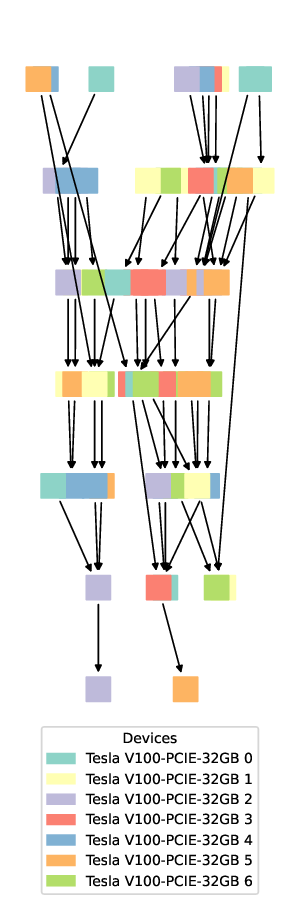

In [1]:
! ../dagger_generator.py --kernels="ijk" --kernel-split='100' --depth=10 --num-tasks=64 --min-width=7 --max-width=7 --buffers-per-kernel="ijk:rw r r" --kernel-dimensions="ijk:2" --use-data-memory --concurrent-kernels="ijk:14" --skips=3 --cdf-mean=2 --cdf-std-dev=0 --graph="mashloaddemo.json" --use-data-memory --handover-in-memory-shuffle --num-memory-shuffles=32
! export IRIS_ARCHS=cuda
! IRIS_ASYNC=1 IRIS_MALLOC_ASYNC=0 IRIS_NSTREAMS=9 IRIS_NCOPY_STREAMS=3 IRIS_HISTORY=1 IRIS_HISTORY_FILE=mashloaddemo.csv ../dagger_runner --graph="mashloaddemo.json" --logfile="time.csv" --repeats=1 --scheduling-policy="roundrobin" --kernels="ijk" --buffers-per-kernel="ijk:rw r r" --kernel-dimensions="ijk:2"  --size=2048 --concurrent-kernels="ijk:14" --use-data-memory
! python ../gantt/gantt.py --dag=mashloaddemo.json --timeline=mashloaddemo.csv --dag-out=64dag.pdf --no-show-kernel-legend --no-show-task-legend --no-show-node-labels
from wand.image import Image as WImage
WImage(filename='./64dag.pdf', resolution=100)

The performance scaling figure was generated with the following:

    problemsize       secs   type
3            64    12.6109  async
12           64    12.4085   sync
9           128    17.2368  async
7           128    28.2446   sync
4           256    33.5710  async
2           256    52.8810   sync
11          512    72.4928  async
0           512   121.9640   sync
1          1024   145.8030  async
8          1024   276.5930   sync
6          2048   291.0990  async
10         2048   512.4230   sync
5          4096   628.8170  async
13         4096  1117.6600   sync


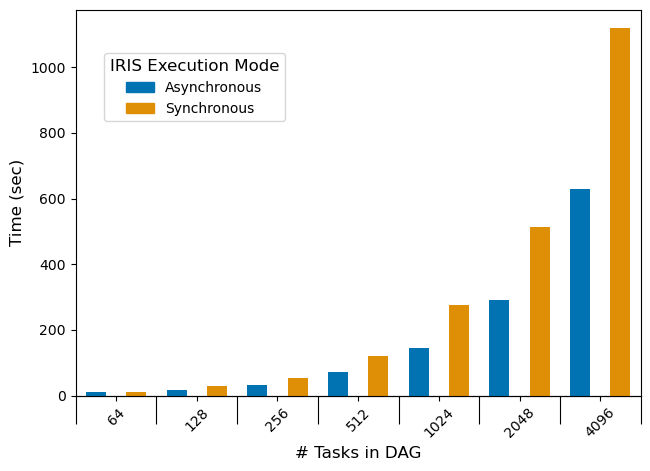

In [2]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as mticker

#synchronous vs asynchronous for each experiment
times = pd.DataFrame({'problemsize':[],'secs':[],'type':[]})
for ind,raw_file in enumerate(glob.glob('results/mashload-*-timeline.csv')):
    prob_size,exec_type = raw_file.split('-')[1],raw_file.split('-')[2]
    cont = pd.read_csv(raw_file)
    row = pd.DataFrame({'problemsize':prob_size,'secs':max(cont['end']),'type':exec_type},index=[ind])
    times = pd.concat([times, row])
times['problemsize'] = times['problemsize'].astype(int)
times.sort_values(['problemsize','type'],inplace=True)
print(times)

palette = sns.color_palette("colorblind", 2)
cmap = dict(zip(set(times['type']), palette))
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
colours = [cmap[times.loc[t]['type']] for t in times.index]

ax = times.plot.bar(x='problemsize',y='secs',color=colours)
plt.xticks(rotation=45)
plt.tight_layout()
ax.set_xticks(np.arange(0.5, 14, 2), [ax.get_xticklabels()[i].get_text() for i in np.arange(0, 14, 2)])#reuse old labels but stagger them by half a point
room_sep_ax = ax.secondary_xaxis(location=0)
room_sep_ax.set_xticks(np.arange(-.5,14.5,2),''*2)
room_sep_ax.tick_params('x', length=20)
ax.set_ylabel(r"Time (sec)",fontsize=12)
ax.set_xlabel(r"# Tasks in DAG",fontsize=12)
plt.legend(title='IRIS Execution Mode', title_fontsize=12, labels=["Asynchronous","Synchronous"], handles=patches, bbox_to_anchor=(0.05, 0.8), loc='center left', borderaxespad=0, frameon=True)
plt.savefig('dagger-sync-vs-async.pdf',bbox_inches = 'tight')
plt.show()


### Additional Timelines

These figures present additional figures (not in the paper) showing a deeper dive of the actual execution schedules of each DAG.

filename is results/mashload-64-async-out.pdf
filename is results/mashload-64-sync-out.pdf
filename is results/mashload-128-async-out.pdf
filename is results/mashload-128-sync-out.pdf
filename is results/mashload-256-async-out.pdf
filename is results/mashload-256-sync-out.pdf
filename is results/mashload-512-async-out.pdf
filename is results/mashload-512-sync-out.pdf
filename is results/mashload-1024-async-out.pdf


   **** Warning: File has some garbage before %PDF- .


filename is results/mashload-1024-sync-out.pdf
filename is results/mashload-2048-async-out.pdf
filename is results/mashload-2048-sync-out.pdf
filename is results/mashload-4096-async-out.pdf
filename is results/mashload-4096-sync-out.pdf


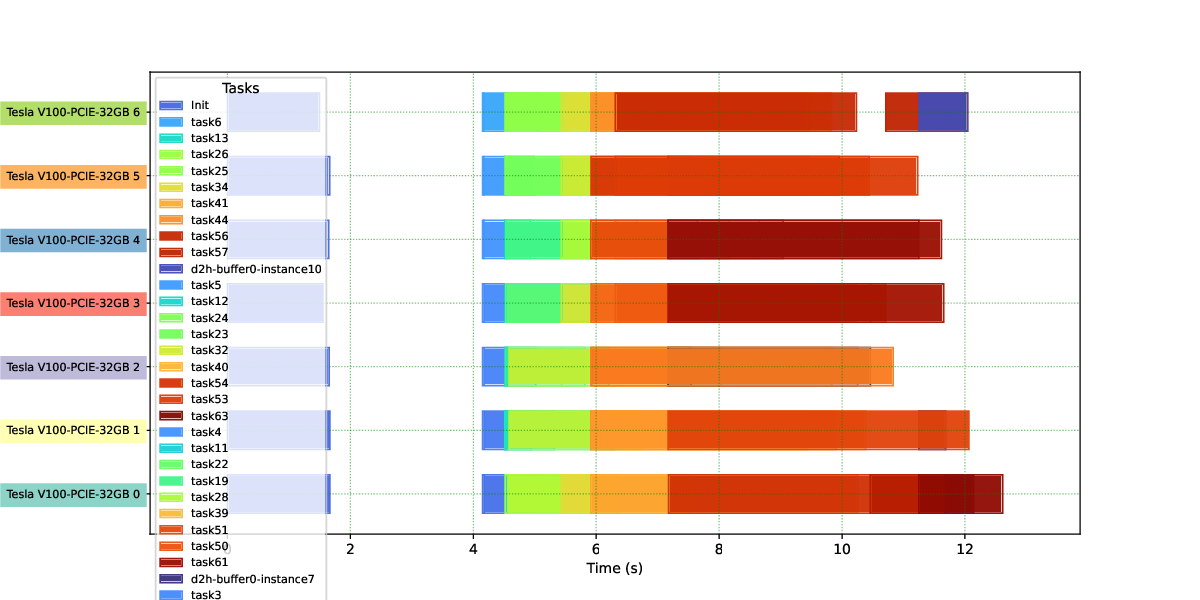

'64 async'

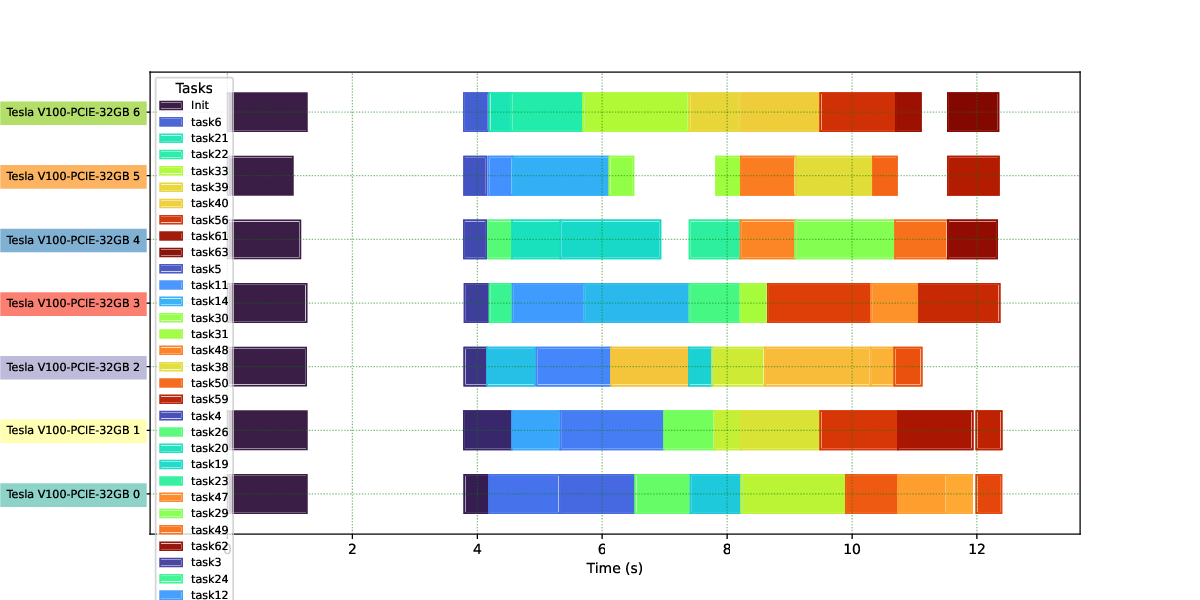

'64 sync'

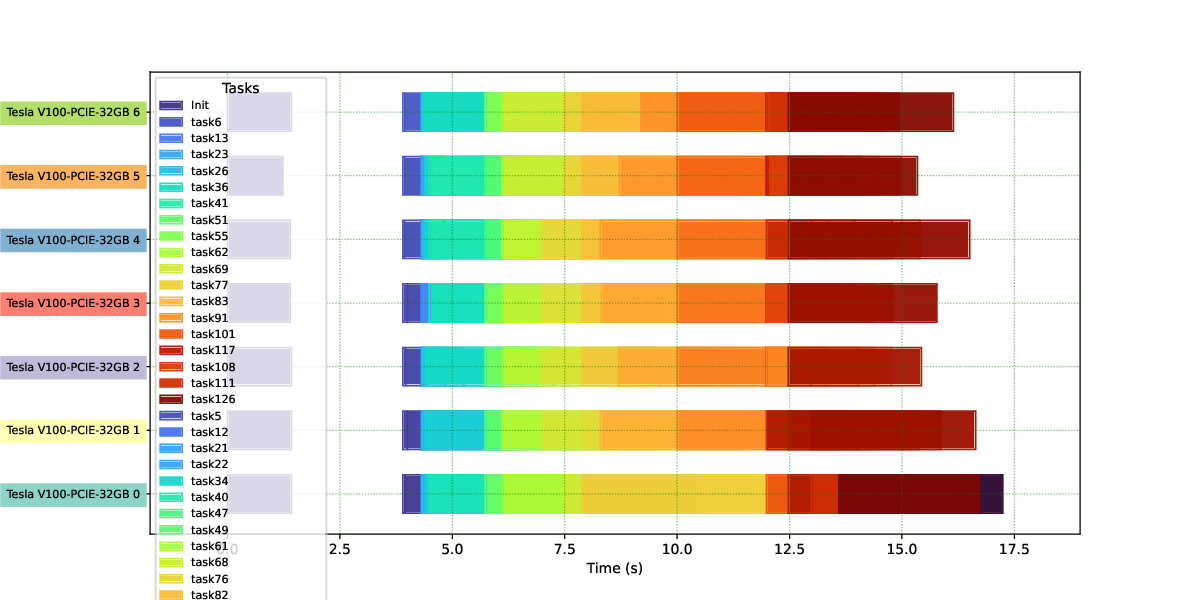

'128 async'

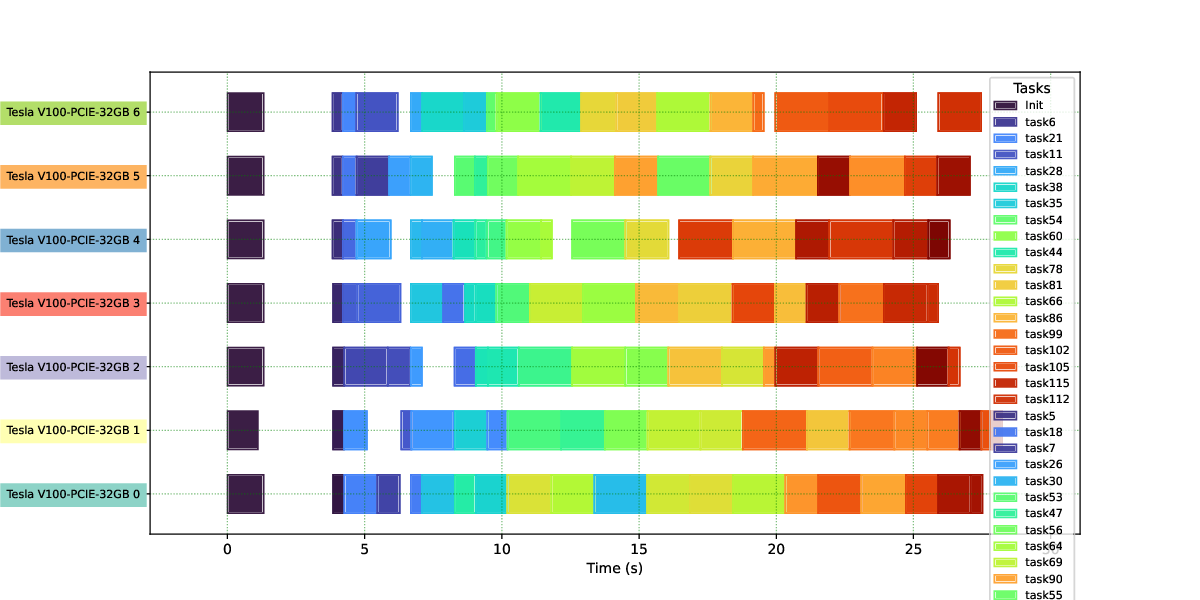

'128 sync'

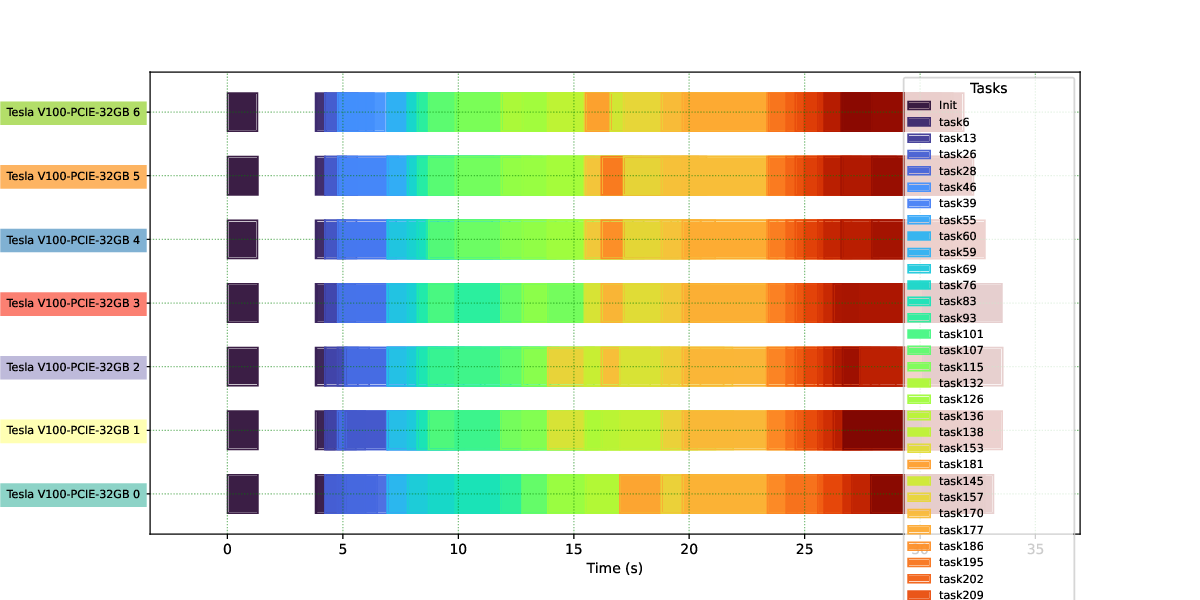

'256 async'

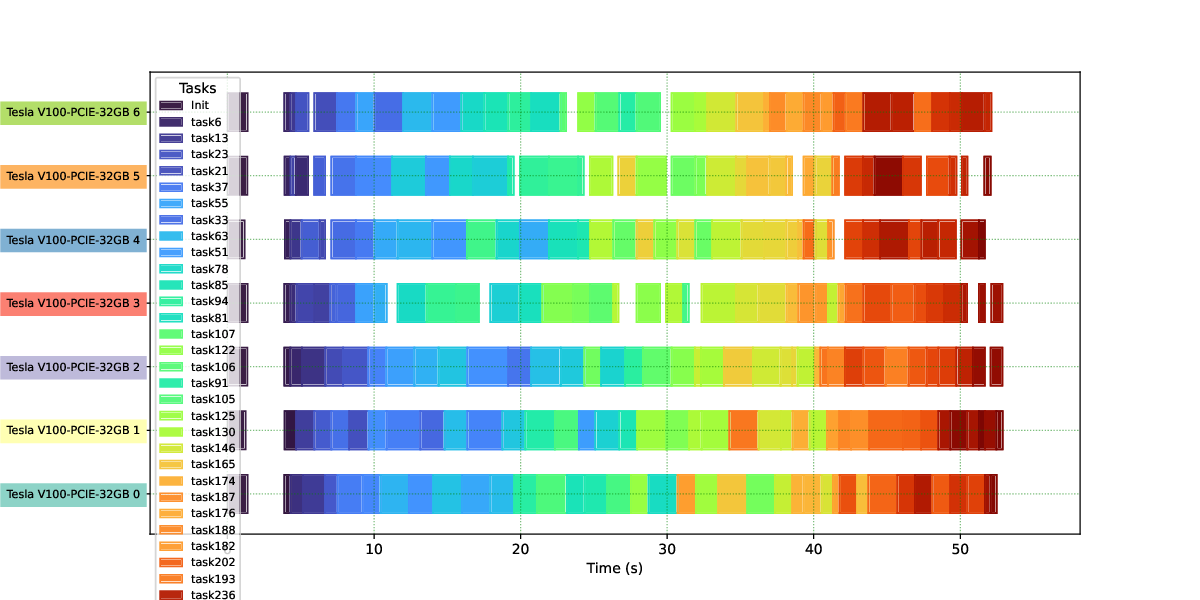

'256 sync'

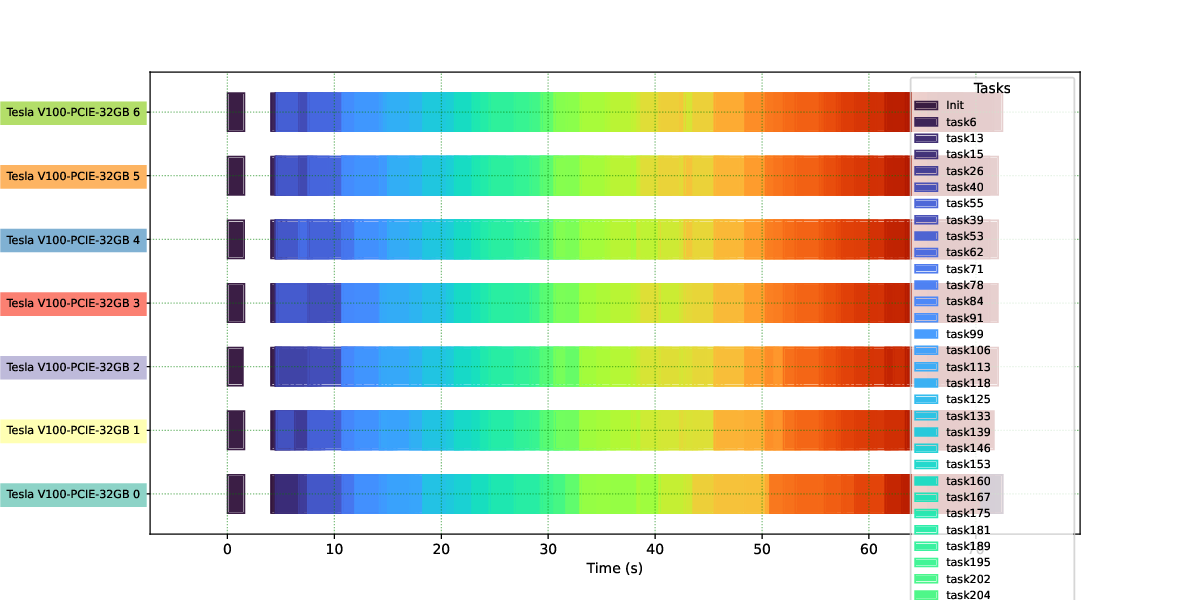

'512 async'

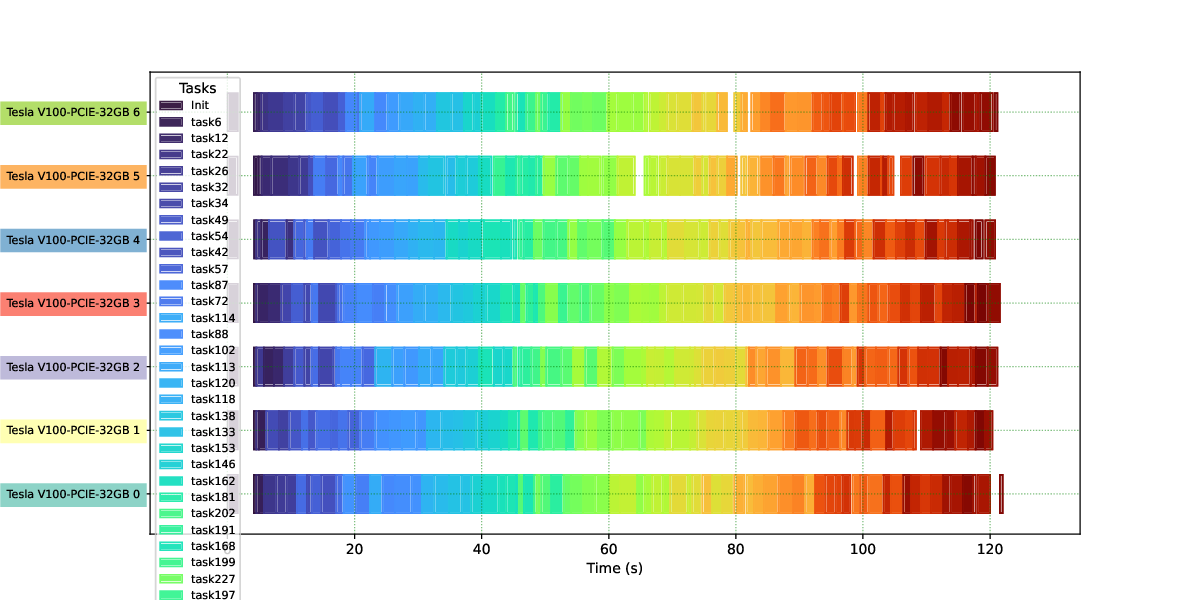

'512 sync'

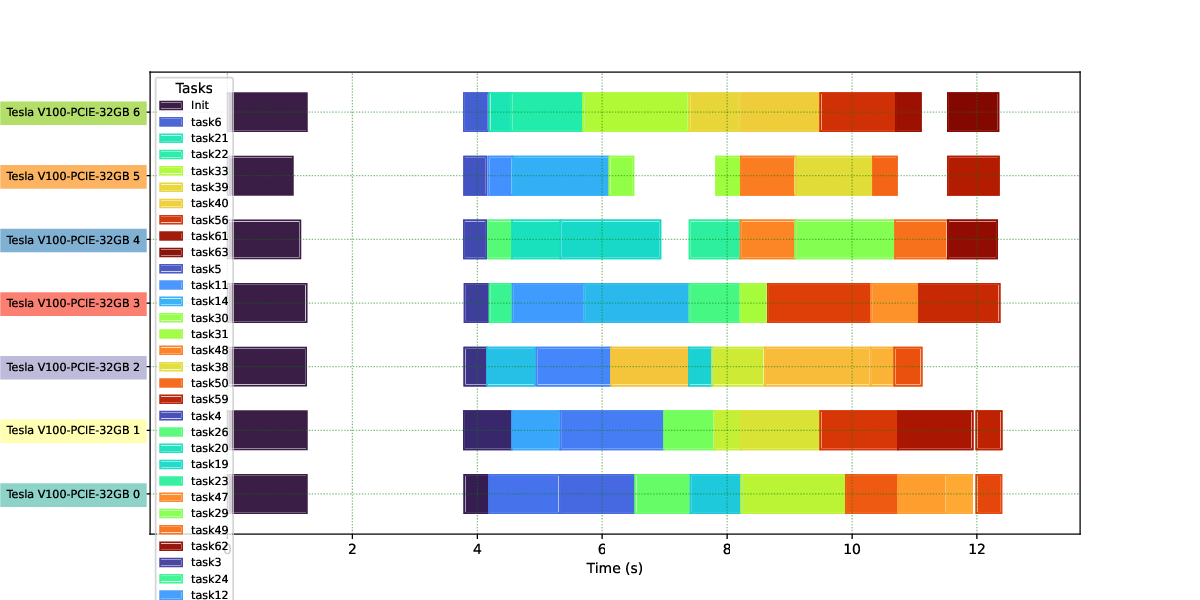

'1024 async'

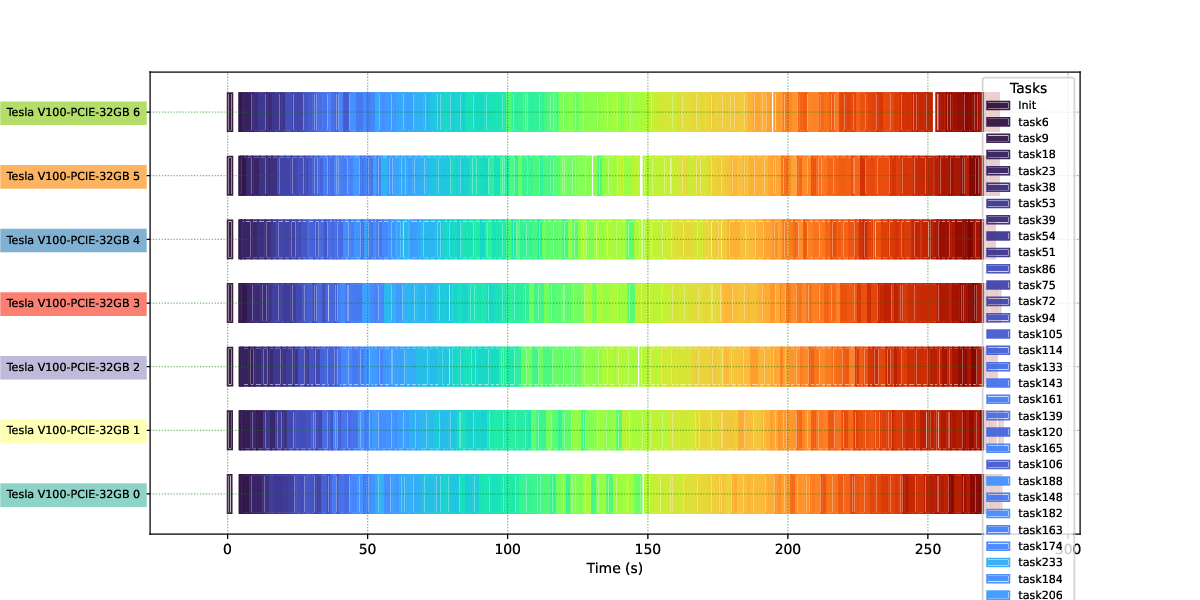

'1024 sync'

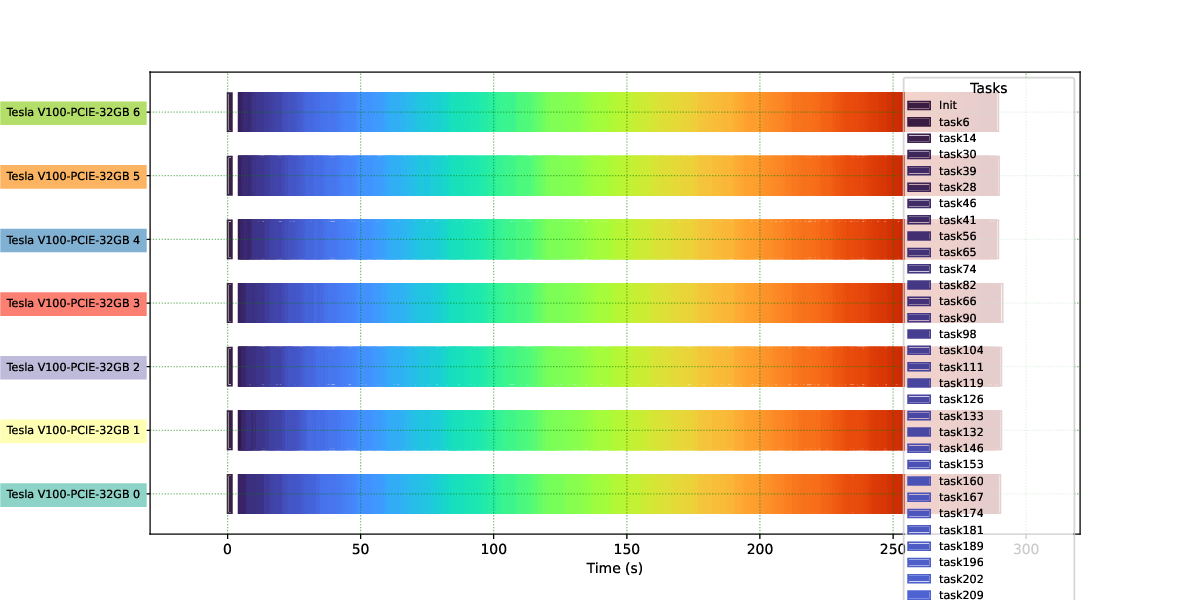

'2048 async'

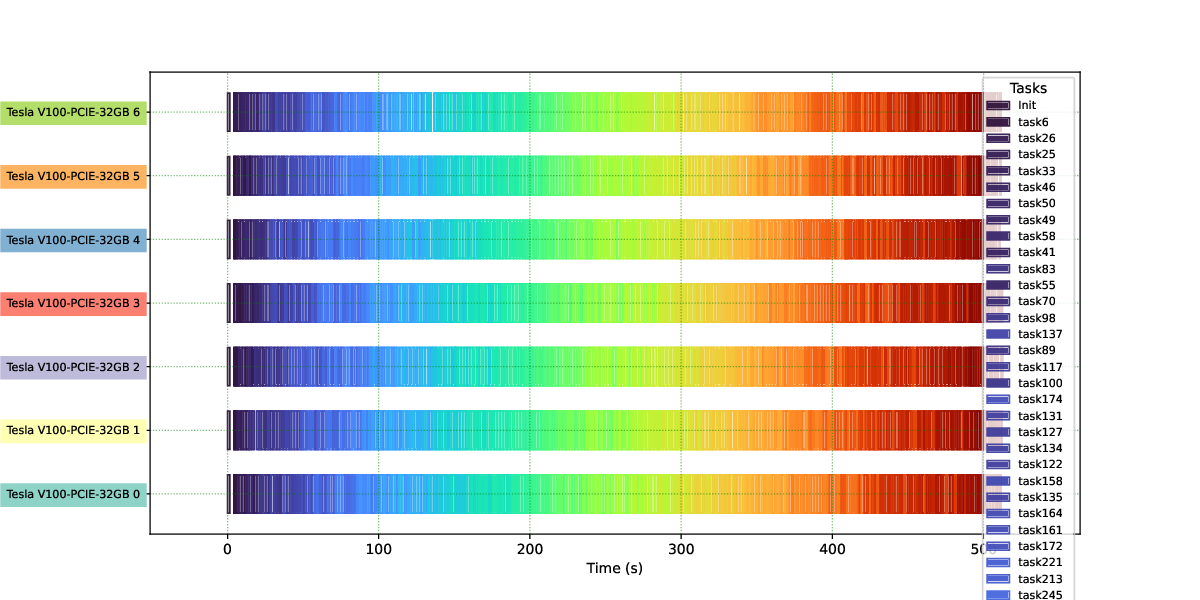

'2048 sync'

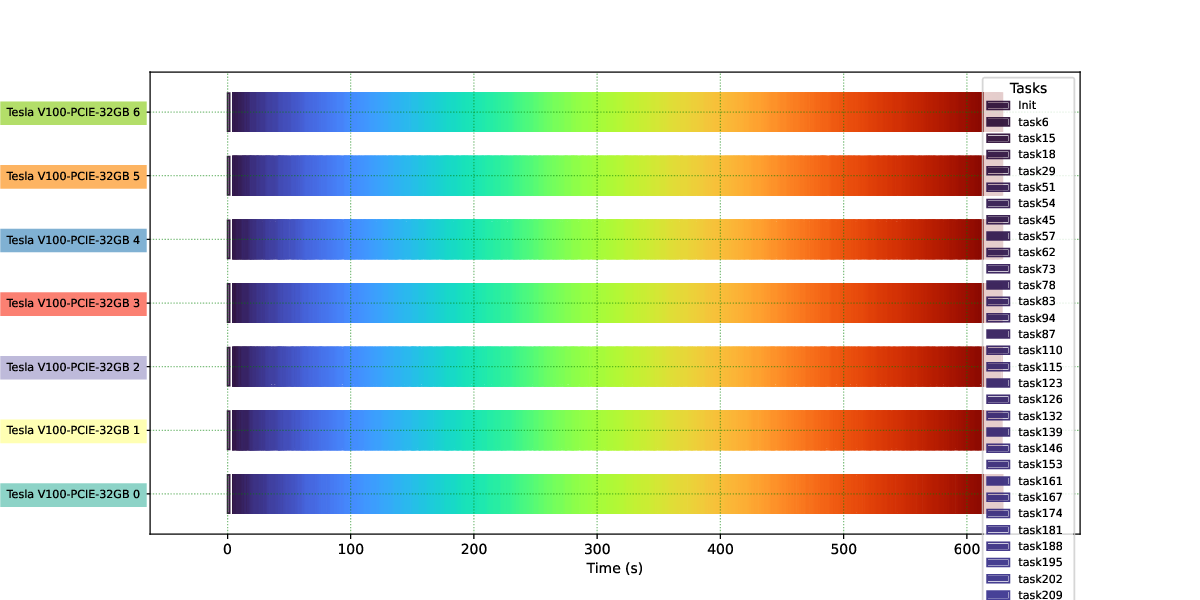

'4096 async'

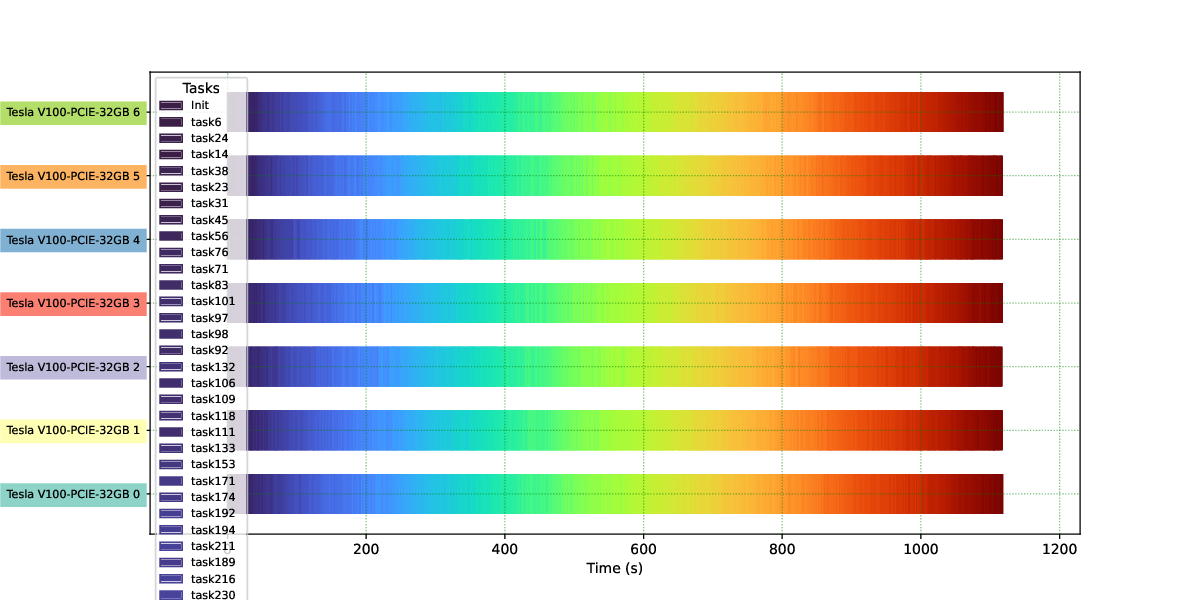

'4096 sync'

In [24]:
from wand.image import Image as WImage
from wand.drawing import Drawing as WDrawing
import glob
import natsort
timeline_images = glob.glob("results/mashload-*.pdf")
timeline_images = natsort.natsorted(timeline_images)
timeline_images
images = []
for i in timeline_images:
    print("filename is {}".format(i))
    img = WImage(filename=i, resolution=100)
    images.append(img)
    caption = "{} {}".format(i.split("-")[1], i.split("-")[2])
    images.append(caption)

display(*images)